In [ ]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from os.path import dirname, join
from scipy.interpolate import RegularGridInterpolator
from dateutil.parser import parse

# Earthdata
from earthdata import DataCollections, DataGranules, Auth, Store

# Credentials to interact with CMR
First we initialize Auth() to get the cloud credentials, if we have a `.netrc` file this can be done automatically

In [ ]:
auth = Auth().login(strategy='netrc')
if auth.authenticated is None:
    # we ask for credentials
    auth.login()
auth

# Define important parameters

In [ ]:
# beaufort sea region
lonrange = [-160, -130]
latrange = [68, 80]
bounding_box = (lonrange[0], latrange[0], lonrange[1], latrange[1])
# Data collection short name
ShortName_sss = "SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5"

In [ ]:
# Severine:
insitu_dir=Path('/home/jovyan/Data/SASSIE/collocation/insitu/')  
sat_dir=Path('/home/jovyan/Data/SASSIE/collocation/satellite/smap_jpl_l3/') 
output_dir=Path('./data/output/') 

#### Querying CMR using `earthdata` to get the `concept_id` for the cloud hosted collection

In [ ]:
# See: https://github.com/nsidc/earthdata
CollectionQuery = DataCollections().short_name(ShortName_sss).cloud_hosted(True)
collections = CollectionQuery.get()

for collection in collections:
    concept_id = collection.concept_id()
    print(concept_id)

# Load in situ SIZRS file for 1 year

In [ ]:
filename=str(insitu_dir) + '/SIZRS_2016.nc'
insitu = xr.open_dataset(filename)
insitu

In [ ]:
# round the time to the closest day
days_from_insitu = pd.to_datetime(insitu.t).round('D')
days = days_from_insitu.values
days

In [ ]:
# we use a Set to avoid repeating queries to the same day to download the data
date_ranges = set()
for day in days:
    start_date = str(day)
    end_date = str(day + np.timedelta64(1, 'D'))
    # or end_date = str(day + np.timedelta64(1, 'D') - np.timedelta64(1, 's')) for 23:59:59 of the same day, the search on CMR is the same.
    date_range = (start_date, end_date)
    date_ranges.add(date_range)
date_ranges

# Download from CMR the granules we want
Since `SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5` is an **8-day running mean** a query to a given day will overlap with 
8 different days and we are only interested in the mid date.

In [ ]:
store = Store(auth) 
for dt in date_ranges:
    download_size = 0
    GranuleQuery = DataGranules().parameters(
        concept_id=concept_id,
        bounding_box=bounding_box,
        temporal=dt)
    granules = GranuleQuery.get()
    # Since our query at this point is for one day only
    dt_middate = parse(str(dt[0])).strftime('%Y%m%d')
    for i in range(0,len(granules)): #granule in granules:
        # The native_id has the mid_date encoded in this case
        if dt_middate in granules[i]["meta"]["native-id"]:
            files = store.get(granules[i:i+1], str(sat_dir)+'/')

# Load the files and interpolate on the in situ

In [ ]:
dates = pd.DatetimeIndex(days)
smap = [] #list of granules to load (size of in situ time)
list_files=[]
for dt in dates:
    filename=str(sat_dir)+'/SMAP_L3_SSS_'+str(dt.year)+str(dt.month).zfill(2)+str(dt.day).zfill(2)+'_8DAYS_V5.0.nc'
    smap.append(xr.open_dataset(filename))
    list_files.append(filename)
    print(filename)

In [ ]:
# make sure file list is unique - pass it to a set and then back to a list.
list_files = list(set(list_files))
list_files

In [ ]:
ds_smap_L3 = xr.open_mfdataset(
    list_files,
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}
    ).sel(longitude=slice(lonrange[0],lonrange[1]), latitude=slice(latrange[1],latrange[0]))
ds_smap_L3

In [ ]:
# # kyla note - now this doesn't work... 

# # TO IMPROVE:
# # Should be able to do the 3D interpolation with interp() but can't find a way to make it work
# # Unfortunately i didn't find a way to keep the original SMAP lat/lon values
# for t in range(0,len(insitu.t)):
#     ds=ds_smap_L3['smap_sss'][t,:,:]
#     tmp=ds.interp(longitude=insitu.x.values[t], latitude=insitu.y.values[t], method='nearest')
#     try:
#         collocation=xr.concat([collocation,tmp], "time", coords='all')
#     except:
#         collocation=tmp
# collocation

In [17]:
# kyla add: 
# 
# 3d interpolation works with unique times...but it gives us a 3-d output that we won't want... so don't do this
collocation_3d = ds_smap_L3.smap_sss.interp(longitude=insitu.x.values, latitude=insitu.y.values, time=insitu.t.values)
collocation_3d


<xarray.DataArray 'smap_sss' (time: 26, latitude: 26, longitude: 26)>
dask.array<transpose, shape=(26, 26, 26), dtype=float32, chunksize=(26, 26, 26), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 -150.0 -150.2 -150.0 ... -150.0 -150.0 -150.0
  * latitude   (latitude) float64 72.0 74.36 75.12 75.98 ... 74.98 76.02 77.05
  * time       (time) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-06T22:39:00
Attributes:
    long_name:              SMAP sea surface salinity
    units:                  1e-3
    standard_name:          sea_surface_salinity
    valid_min:              0
    valid_max:              45
    coverage_content_type:  physicalMeasurement

In [18]:
# instead, create a new dataset containing the x/y/t values we want to interpolate to, along a new dimension we call "points":
interp_to= xr.Dataset(
    dict(
        longitude = xr.DataArray(insitu.x.values, dims='points'),
        latitude = xr.DataArray(insitu.y.values, dims='points'),
        time = xr.DataArray(insitu.t.values, dims='points'),
    )
)

# now, we can imterpolate to that to get the interpolated data along the points dimension:
collocation = ds_smap_L3['smap_sss'].interp(interp_to)
collocation

<xarray.DataArray 'smap_sss' (points: 26)>
dask.array<dask_aware_interpnd, shape=(26,), dtype=float32, chunksize=(26,), chunktype=numpy.ndarray>
Coordinates:
    longitude  (points) float64 -150.0 -150.2 -150.0 ... -150.0 -150.0 -150.0
    latitude   (points) float64 72.0 74.36 75.12 75.98 ... 74.98 76.02 77.05
    time       (points) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-06T22:...
Dimensions without coordinates: points
Attributes:
    long_name:              SMAP sea surface salinity
    units:                  1e-3
    standard_name:          sea_surface_salinity
    valid_min:              0
    valid_max:              45
    coverage_content_type:  physicalMeasurement

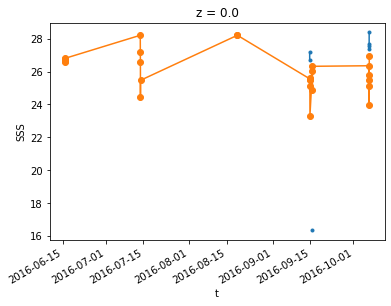

In [20]:
# plot to check... 
collocation.plot(x='time', marker='.')
insitu.SSS.plot(marker='o')

# SAVE output file

In [ ]:
insitu['smap_sss']=collocation
insitu

In [ ]:
ds=insitu.rename({'x': 'lon_insitu','y': 'lat_insitu','z': 'depth_insitu','t': 't_insitu',
                  'SSS': 'SSS_insitu','SST': 'SST_insitu',
                  'smap_sss': 'SSS_smap','time': 't_smap'})

In [ ]:
ds = ds.drop(['longitude','latitude'])
ds

In [ ]:
ds.SSS_insitu.attrs['long_name'] = 'SIZR in situ salinity'
ds.SSS_insitu.attrs['units'] = '1e-3'
ds.SST_insitu.attrs['long_name'] = 'SIZR in situ salinity'
ds.SST_insitu.attrs['units'] = 'degC'
ds

In [ ]:
# Save to Disk
fileout=str(output_dir) + '/SIZRS_SMAP_collocation_2016.nc'
ds.to_netcdf(fileout)